In [1]:
import zipfile
import os

zip_path = "/content/Root Canal.v1i.yolov11.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted!")


Dataset extracted!


In [2]:
import os

for root, dirs, files in os.walk(extract_path):
    print(root)
    for name in dirs:
        print("📂", name)
    for name in files[:5]:  # Just preview first 5 files
        print("📄", name)
    break  # only show top-level


/content/dataset
📂 test
📂 valid
📂 train
📄 data.yaml
📄 README.roboflow.txt
📄 README.dataset.txt


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import UnidentifiedImageError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# Filling = 0, others = Root_Canal (1)

IMG_SIZE = 64
NUM_CLASSES = 2
CLASS_NAMES = ["Filling", "Root_Canal"]
dataset_root = "/content/dataset"

def load_data(split):
    split_images = os.path.join(dataset_root, split, "images")
    split_labels = os.path.join(dataset_root, split, "labels")
    X = []
    y = []

    for file in os.listdir(split_images):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(split_images, file)
        label_path = os.path.join(split_labels, os.path.splitext(file)[0] + ".txt")

        try:
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0

            with open(label_path, 'r') as f:
                first_line = f.readline().strip()
                class_id = int(first_line.split()[0])
                binary_label = 0 if class_id == 0 else 1

                X.append(img_array)
                y.append(binary_label)

        except Exception as e:
            print(f"Skipping {file}: {e}")
            continue

    return np.array(X), np.array(y)


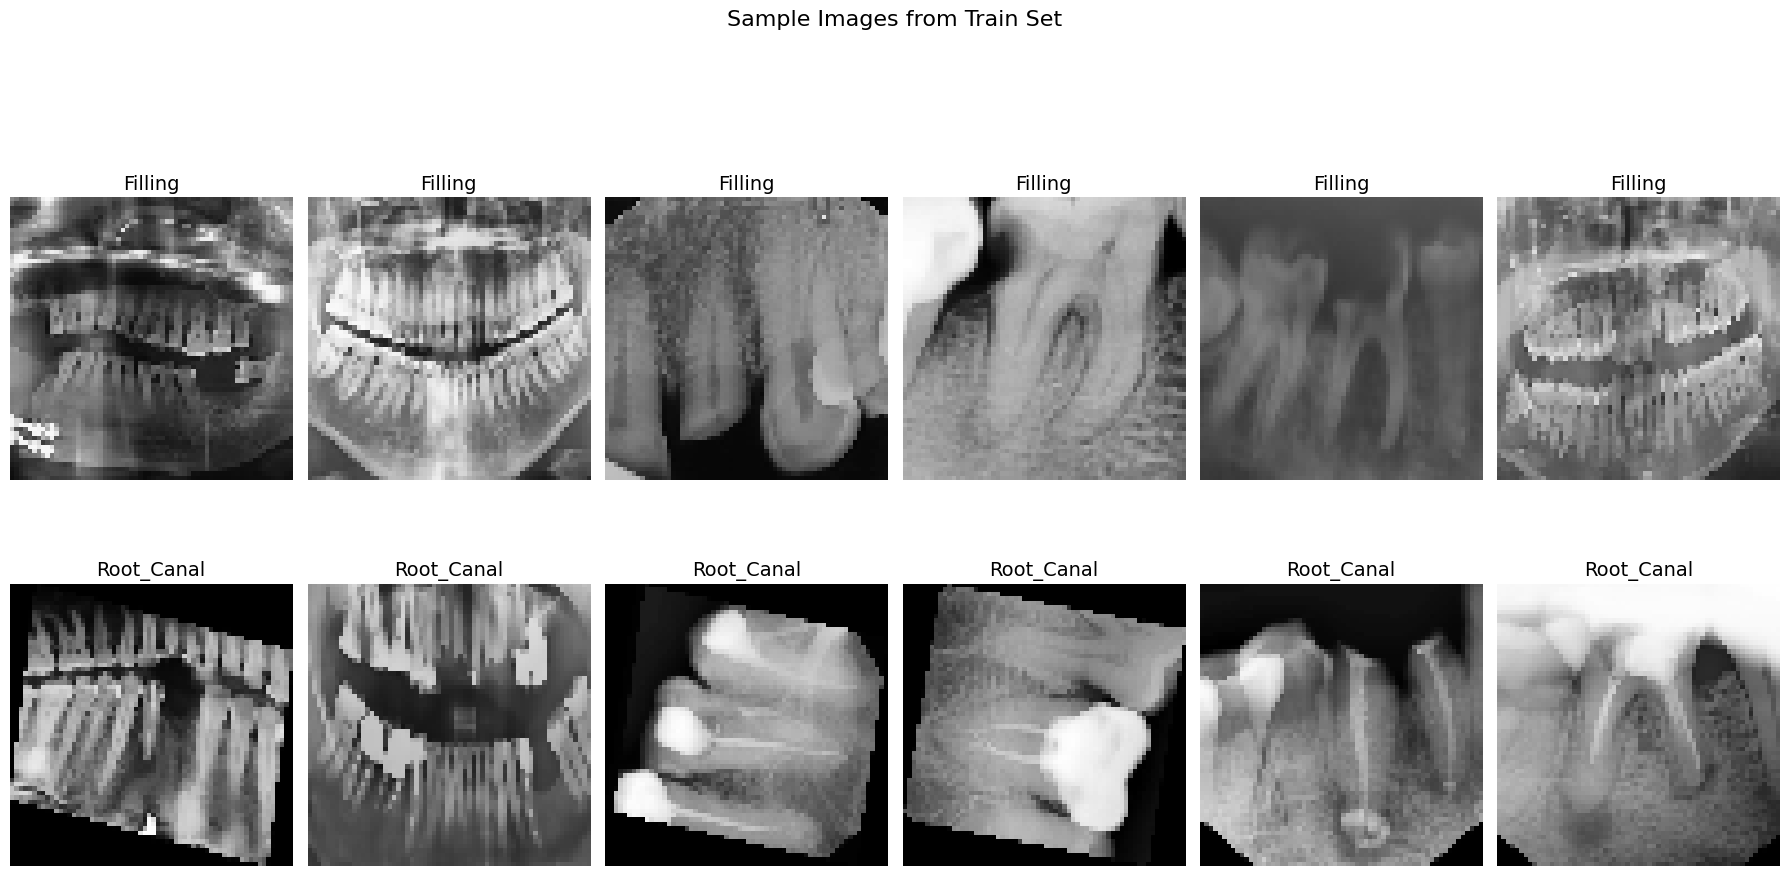

In [11]:
def show_sample_images(X, y, title):
    fig, axes = plt.subplots(2, 6, figsize=(18, 10))
    fig.suptitle(title, fontsize=16)

    axes = axes.flatten()

    class_0 = np.where(y == 0)[0]
    class_1 = np.where(y == 1)[0]

    if len(class_0) >= 6 and len(class_1) >= 6:

        sample_indices = np.concatenate([class_0[:6], class_1[:6]])
        for i, idx in enumerate(sample_indices):
            axes[i].imshow(X[idx])
            axes[i].axis("off")
            axes[i].set_title(CLASS_NAMES[y[idx]], fontsize=14)
    else:

        available_indices = np.concatenate([class_0[:min(6, len(class_0))],
                                           class_1[:min(6, len(class_1))]])
        for i, idx in enumerate(available_indices):
            if i < 12:
                axes[i].imshow(X[idx])
                axes[i].axis("off")
                axes[i].set_title(CLASS_NAMES[y[idx]], fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


show_sample_images(X_train, y_train, "Sample Images from Train Set")

In [15]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights_arr)}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(7.071428571428571), 1: np.float64(0.5380434782608695)}


In [26]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=50,
    # batch_size=4,
    verbose=1,
    class_weight=class_weights
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.9424 - loss: 0.7691 - val_accuracy: 0.8588 - val_loss: 9.6852
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8931 - loss: 1.2305 - val_accuracy: 0.8824 - val_loss: 9.0196
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9464 - loss: 0.7078 - val_accuracy: 0.8588 - val_loss: 8.7989
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9635 - loss: 0.2398 - val_accuracy: 0.8588 - val_loss: 8.5689
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9433 - loss: 0.3683 - val_accuracy: 0.8588 - val_loss: 8.4025
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9597 - loss: 1.1804 - val_accuracy: 0.8588 - val_loss: 8.4563
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9720 - loss: 1.3635 - val_accuracy: 0.8588 - val_loss: 8.5776
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9628 - loss: 0.2867 - val_accuracy: 0.8588 - val

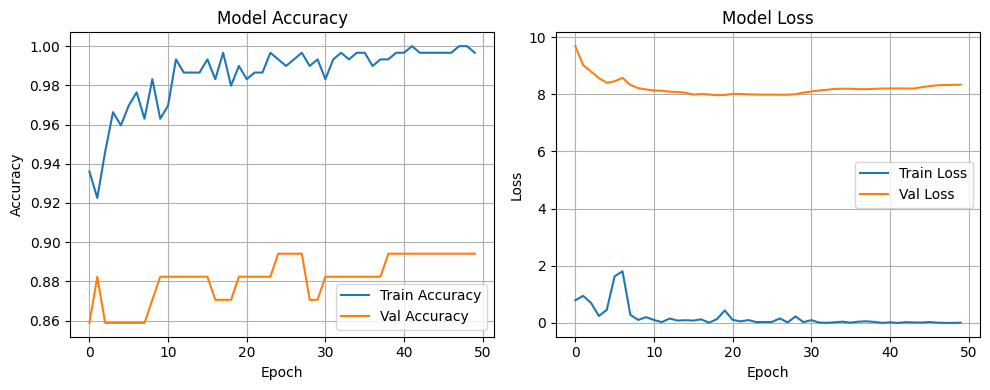

In [37]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8423 - loss: 11.7469

Test Accuracy: 0.8571
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Classification Report:
              precision    recall  f1-score   support

     Filling       0.00      0.00      0.00         4
  Root_Canal       0.90      0.95      0.92        38

    accuracy                           0.86        42
   macro avg       0.45      0.47      0.46        42
weighted avg       0.81      0.86      0.84        42



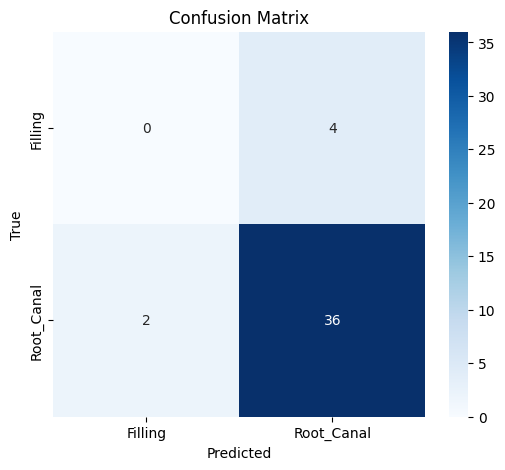

In [38]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [39]:
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Precision: 0.8143
Recall:    0.8571
F1 Score:  0.8352


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


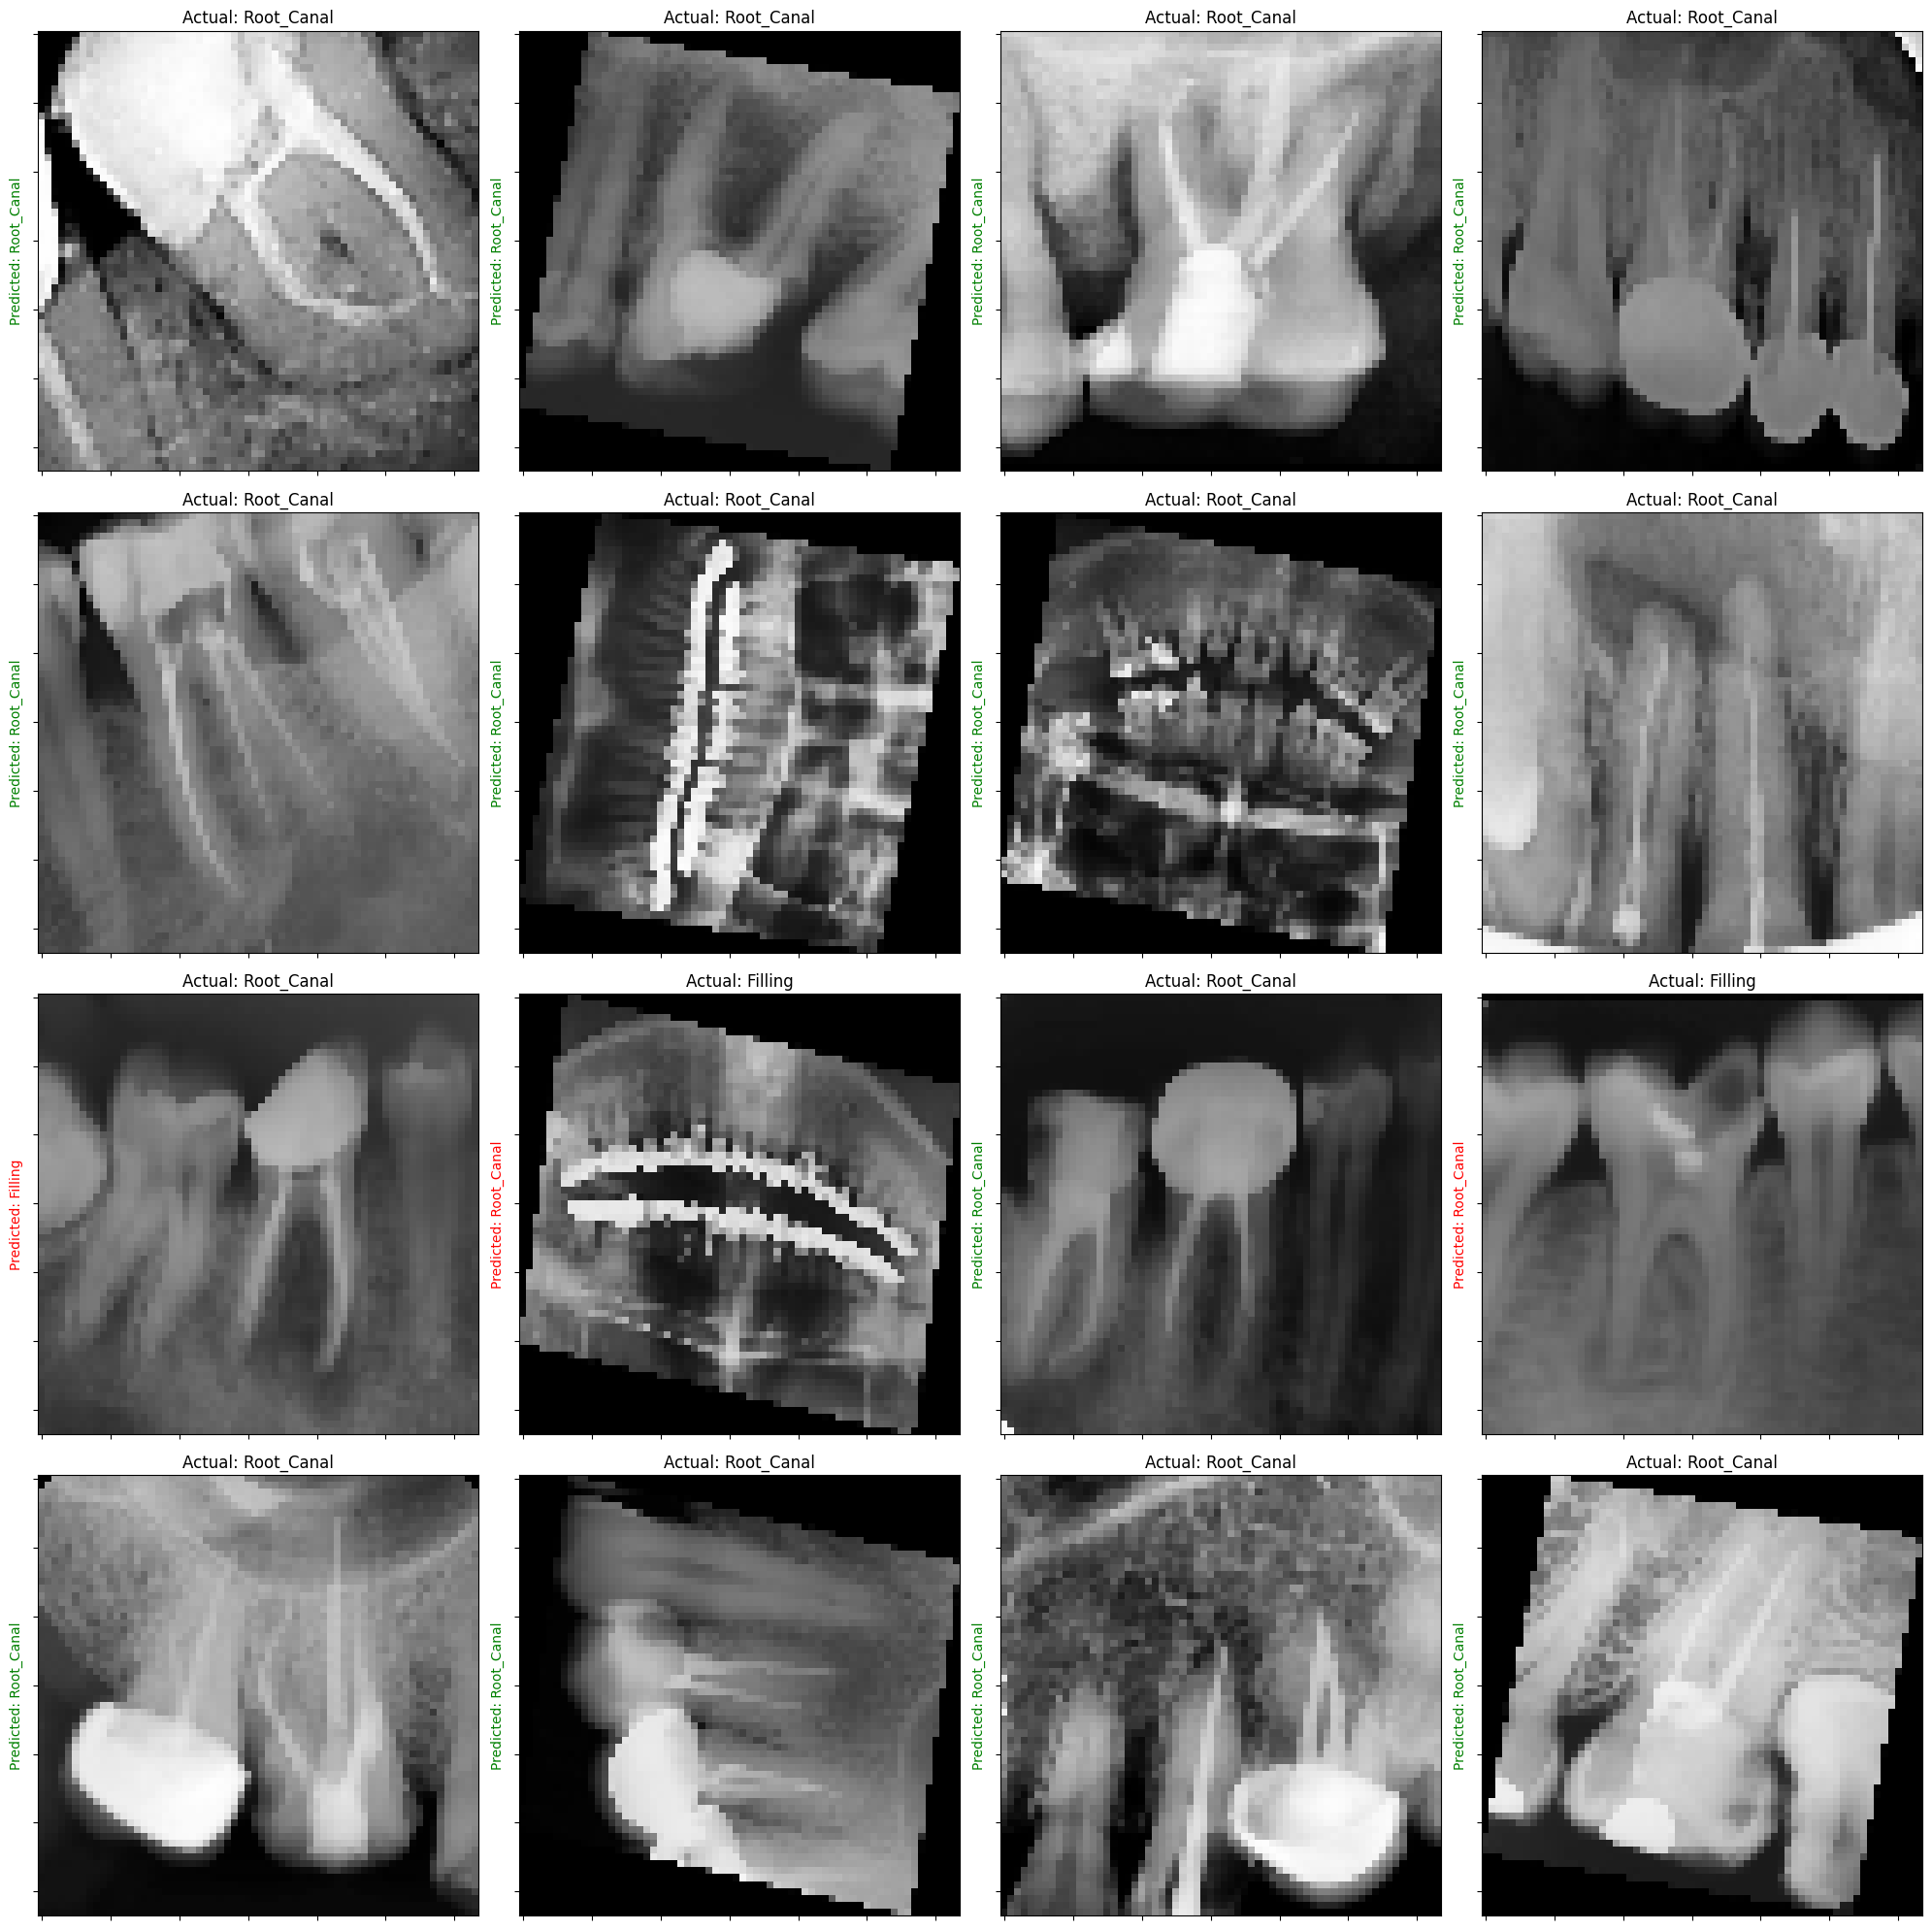

In [42]:
def show_predictions(X_data, y_true, model, scaler):
    # Get predictions
    X_flat = X_data.reshape(X_data.shape[0], -1)
    X_scaled = scaler.transform(X_flat)
    y_pred = model.predict(X_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Select samples to display (up to 16)
    num_samples = min(16, len(X_data))
    indices = np.random.choice(len(X_data), num_samples, replace=False)

    # Create figure
    plt.figure(figsize=(20, 20))

    for i, idx in enumerate(indices):
        ax = plt.subplot(4, 4, i + 1)

        # Display image
        plt.imshow(X_data[idx])

        # Set titles and labels
        actual_class = CLASS_NAMES[y_true[idx]]
        pred_class = CLASS_NAMES[y_pred_classes[idx]]

        # Color code the prediction (green if correct, red if incorrect)
        color = 'green' if actual_class == pred_class else 'red'

        plt.title(f"Actual: {actual_class}")
        plt.ylabel(f"Predicted: {pred_class}", fontdict={'color': color})

        # Remove tick labels
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

    plt.tight_layout()
    plt.show()

# Show predictions only for test set
show_predictions(X_test, y_test, model, scaler)